<a href="https://colab.research.google.com/github/Julien57860/DATA-4-auditors_IAEMetz/blob/main/Projet_DATA4AUDITORSJulienLounis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyse de performance: Gestion Active vs Gestion Passive


#  I) Préparation de la base de donnée

## 1) Importation des bibliothèques

In [ ]:
# Importation des bibliothèques
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from scipy.optimize import minimize
import statsmodels.api as sm


## 2) Définition des Variables

In [ ]:

# Définition des fonds passifs et actifs
fonds_passifs = ['VOO', 'IVV', 'VTI', 'SCHX', 'DIA', 'VYM', 'ITOT', 'MGK', 'SPLG', 'USMV']
fonds_actifs = ['FCNTX', 'TRBCX', 'AGTHX', 'VWUSX', 'OLGAX', 'MADVX', 'FGRIX', 'VPMCX', 'PRGFX', 'DODGX']
indice_benchmark = 'SPY'

# Frais de gestion annuels pour chaque fonds (%)
frais_gestion_passifs = {
    'VOO': 0.03, 'IVV': 0.03, 'VTI': 0.03, 'SCHX': 0.03, 'DIA': 0.16,
    'VYM': 0.06, 'ITOT': 0.03, 'MGK': 0.07, 'SPLG': 0.03, 'USMV': 0.15
}

frais_gestion_actifs = {
    'FCNTX': 0.85, 'TRBCX': 0.70, 'AGTHX': 0.65, 'VWUSX': 0.34, 'OLGAX': 0.70,
    'MADVX': 0.53, 'FGRIX': 0.48, 'VPMCX': 0.41, 'PRGFX': 0.69, 'DODGX': 0.52
}

## 3) Téléchargement des Données

In [ ]:
## Téléchargement des Données

def telecharger_donnees(liste_fonds, debut='2015-01-01', fin='2024-01-01'):
    return yf.download(liste_fonds, start=debut, end=fin)['Close']

# Récupération des données des fonds actifs, passifs et du benchmark
donnees_fonds_actifs = telecharger_donnees(fonds_actifs)
donnees_fonds_passifs = telecharger_donnees(fonds_passifs)
donnees_benchmark = telecharger_donnees([indice_benchmark])

# Fusion des indices actifs et passifs
indice_actif_moyen = donnees_fonds_actifs.mean(axis=1)
indice_passif_moyen = donnees_fonds_passifs.mean(axis=1)

# Création du DataFrame Global
donnees_globales = pd.DataFrame({
    'Fonds Actifs': indice_actif_moyen,
    'Fonds Passifs': indice_passif_moyen,
    'Benchmark': donnees_benchmark[indice_benchmark]
})

[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


# II) Analyse des performance financière

## 1) Ratio de Performance

In [ ]:
rendements = donnees_globales.pct_change().dropna()

# Fonction pour calculer les ratios de performance
def calculer_performance(rendements):
    rendement_annuel = rendements.mean() * 252
    volatilite_annuelle = rendements.std() * np.sqrt(252)
    ratio_sharpe = rendement_annuel / volatilite_annuelle

    rendements_negatifs = rendements[rendements < 0]
    ratio_sortino = rendement_annuel / (rendements_negatifs.std() * np.sqrt(252))

    return pd.DataFrame({
        'Rendement Annuel': rendement_annuel,
        'Volatilité': volatilite_annuelle,
        'Sharpe': ratio_sharpe,
        'Sortino': ratio_sortino
    })

# Définition des périodes
periode_court_terme = 252  # 1 an
periode_moyen_terme = 252 * 3  # 3 ans

# Calcul des performances pour chaque horizon temporel
performances_court_terme = calculer_performance(rendements.tail(periode_court_terme))
performances_moyen_terme = calculer_performance(rendements.tail(periode_moyen_terme))
performances_long_terme = calculer_performance(rendements)  # Toute la période

# Concaténer les résultats pour un affichage clair
tableau_performance = pd.concat(
    [performances_court_terme, performances_moyen_terme, performances_long_terme],
    axis=1,
    keys=['Court Terme (1 an)', 'Moyen Terme (3 ans)', 'Long Terme (Toute la période)']
)

# Affichage formaté
pd.set_option("display.float_format", "{:.4f}".format)  # Limite les décimales pour la lisibilité
print(tableau_performance)



              Court Terme (1 an)                            \
                Rendement Annuel Volatilité Sharpe Sortino   
Fonds Actifs              0.2953     0.1405 2.1025  3.4799   
Fonds Passifs             0.2456     0.1268 1.9373  3.1835   
Benchmark                 0.2564     0.1314 1.9515  3.2450   

              Moyen Terme (3 ans)                            \
                 Rendement Annuel Volatilité Sharpe Sortino   
Fonds Actifs               0.0882     0.1940 0.4548  0.6576   
Fonds Passifs              0.1057     0.1708 0.6188  0.8878   
Benchmark                  0.1118     0.1757 0.6362  0.9179   

              Long Terme (Toute la période)                            
                           Rendement Annuel Volatilité Sharpe Sortino  
Fonds Actifs                         0.1321     0.1948 0.6783  0.8268  
Fonds Passifs                        0.1270     0.1806 0.7034  0.8424  
Benchmark                            0.1279     0.1810 0.7065  0.8552  


##  2) Visualisation des rendements

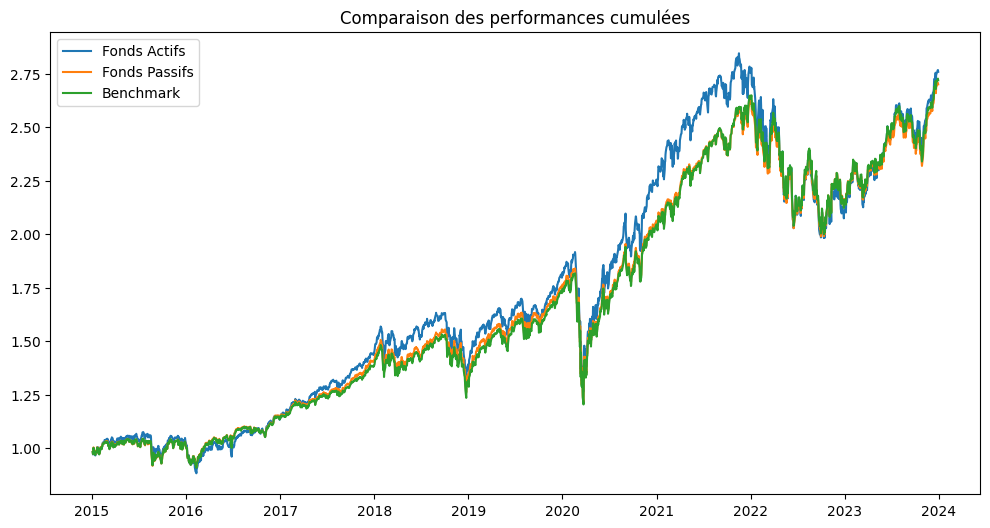

<ipython-input-11-c179099e3347>:10: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  rendements_annuels = rendements.resample('Y').apply(lambda x: (1 + x).prod() - 1)


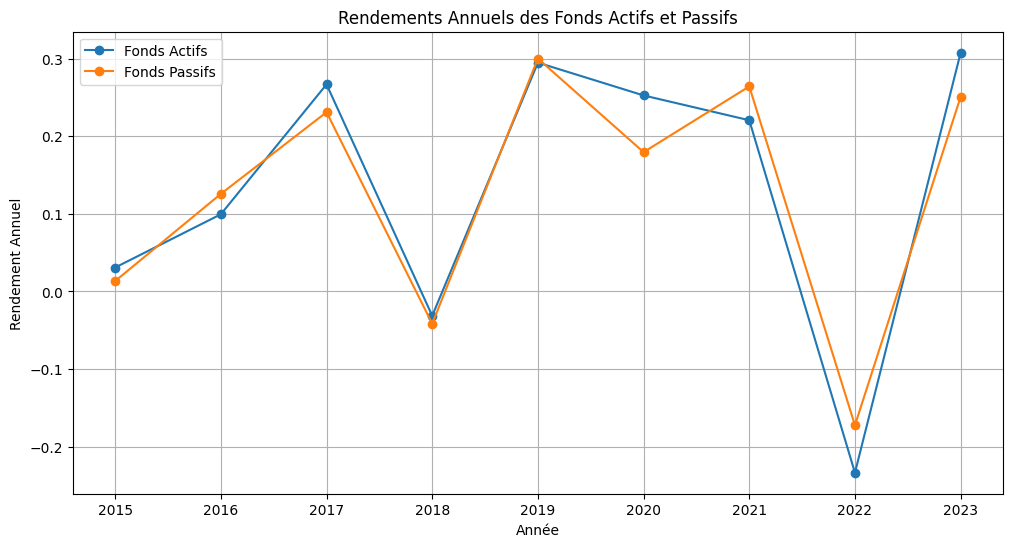

In [ ]:
# 1) Évolution des rendements cumulés
plt.figure(figsize=(12,6))
plt.plot((1 + rendements).cumprod(), label=['Fonds Actifs', 'Fonds Passifs', 'Benchmark'])
plt.legend()
plt.title("Comparaison des performances cumulées")
plt.show()

## 2) Contribution aux Rendements par Année

rendements_annuels = rendements.resample('Y').apply(lambda x: (1 + x).prod() - 1)
rendements_annuels.index = rendements_annuels.index.year

plt.figure(figsize=(12,6))
for portefeuille in ['Fonds Actifs', 'Fonds Passifs']:
    plt.plot(rendements_annuels.index, rendements_annuels[portefeuille], marker='o', label=portefeuille)
plt.title("Rendements Annuels des Fonds Actifs et Passifs")
plt.xlabel("Année")
plt.ylabel("Rendement Annuel")
plt.legend()
plt.grid()
plt.show()


## Rolling ratio de Sharpe sur 1 an (252 jours)

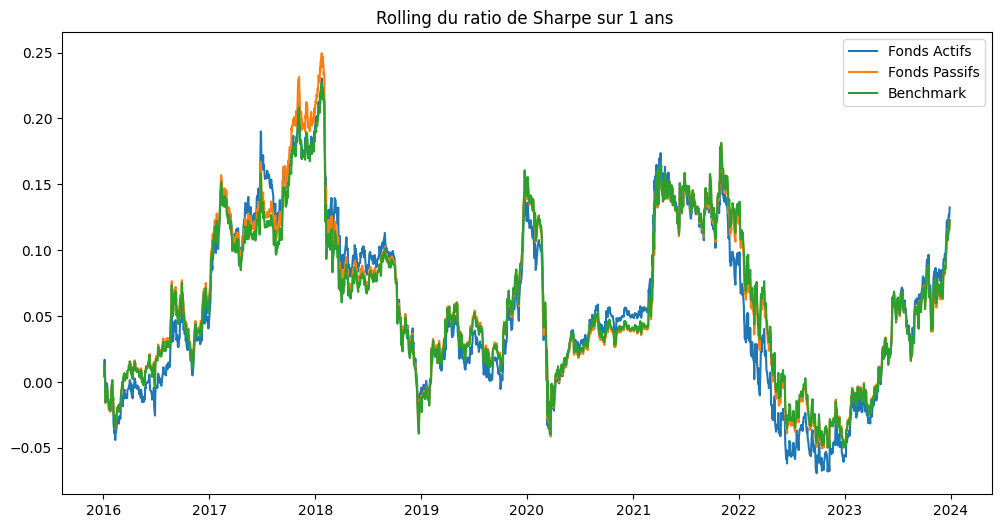

In [ ]:
## Évolution du ratio de Sharpe sur 1 an (252 jours)
ratio_sharpe_glissant = rendements.rolling(window=252).mean() / rendements.rolling(window=252).std()
plt.figure(figsize=(12,6))
plt.plot(ratio_sharpe_glissant)
plt.title("Rolling du ratio de Sharpe sur 1 ans ")
plt.legend(['Fonds Actifs', 'Fonds Passifs', 'Benchmark'])
plt.show()


## 3) Matrice de corrélation des rendements

Matrice de corrélation des rendements :
               Fonds Actifs  Fonds Passifs  Benchmark
Fonds Actifs         1.0000         0.9810     0.9838
Fonds Passifs        0.9810         1.0000     0.9985
Benchmark            0.9838         0.9985     1.0000


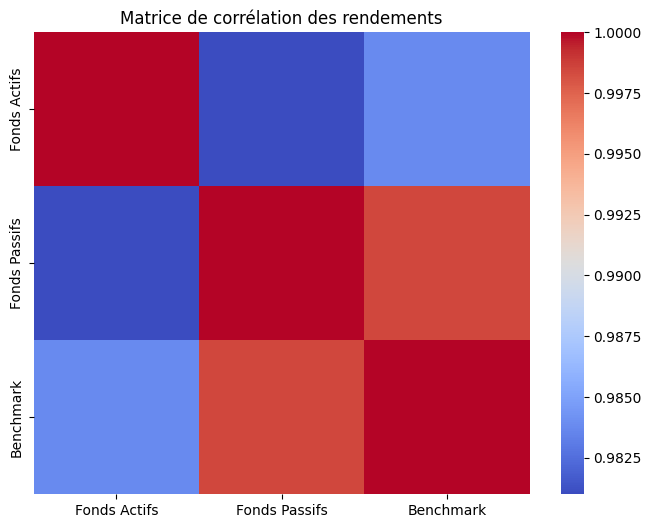

In [ ]:
# Corrélation entre les rendements
corr_matrix = rendements.corr()
print("Matrice de corrélation des rendements :")
print(corr_matrix)

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title('Matrice de corrélation des rendements')
plt.show()


# II) Analyse du risque

## 1) Calcul de la VaR (Value at Risk)


 VaR du Portefeuille des Fonds Passifs par année:
Date
2015    0.0134
2016    0.1257
2017    0.2309
2018   -0.0416
2019    0.3000
2020    0.1795
2021    0.2641
2022   -0.1723
2023    0.2507
Name: Fonds Passifs, dtype: float64

 VaR du Portefeuille des Fonds Actifs par année:
Date
2015    0.0308
2016    0.0995
2017    0.2667
2018   -0.0313
2019    0.2947
2020    0.2525
2021    0.2205
2022   -0.2334
2023    0.3075
Name: Fonds Actifs, dtype: float64


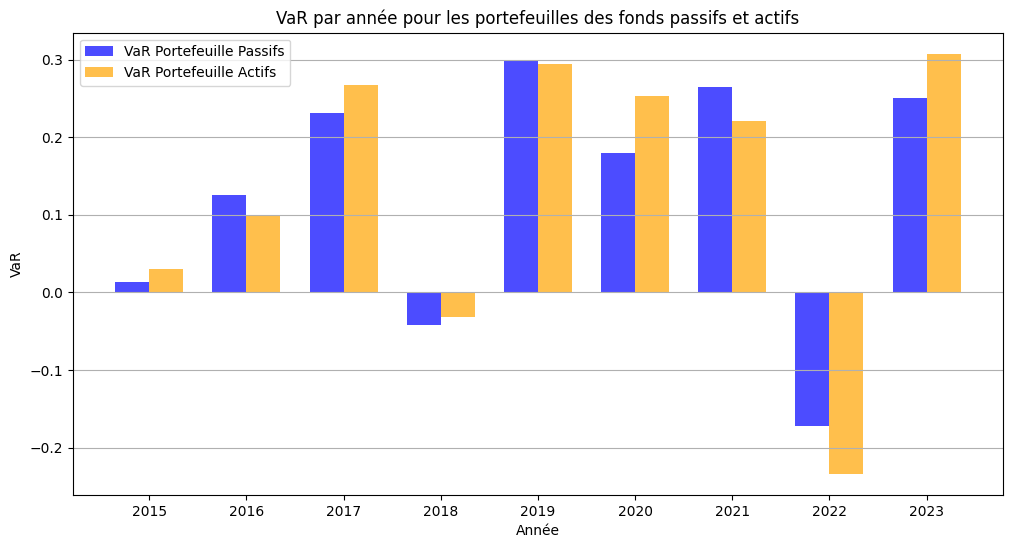

In [ ]:
# Calcul de la VaR (Value at Risk)
def calcul_VaR(rendements, seuil=0.05):
    return np.percentile(rendements, seuil * 100)

# Calcul de la VaR pour les portefeuilles passifs et actifs sur les rendements annuels
var_annuelle_passifs = rendements_annuels['Fonds Passifs'].apply(calcul_VaR)
var_annuelle_actifs = rendements_annuels['Fonds Actifs'].apply(calcul_VaR)

# Affichage des résultats
print("\n VaR du Portefeuille des Fonds Passifs par année:")
print(var_annuelle_passifs)

print("\n VaR du Portefeuille des Fonds Actifs par année:")
print(var_annuelle_actifs)

# Visualisation des résultats avec un graphique à barres
plt.figure(figsize=(12, 6))

# Barres pour la VaR du portefeuille des fonds passifs
bar_width = 0.35  # Largeur des barres
index = np.arange(len(var_annuelle_passifs))  # Position des barres

# Tracer les barres pour chaque portefeuille (passif et actif)
plt.bar(index, var_annuelle_passifs, bar_width, label="VaR Portefeuille Passifs", color='blue', alpha=0.7)
plt.bar(index + bar_width, var_annuelle_actifs, bar_width, label="VaR Portefeuille Actifs", color='orange', alpha=0.7)

# Ajouter les titres et labels
plt.title("VaR par année pour les portefeuilles des fonds passifs et actifs")
plt.xlabel("Année")
plt.ylabel("VaR")

# Extraire les années de l'index (en cas de problème avec l'attribut 'year')
# Si l'index est de type datetime, on peut utiliser .year, sinon, on peut convertir les valeurs en années.
years = var_annuelle_passifs.index.year if isinstance(var_annuelle_passifs.index, pd.DatetimeIndex) else var_annuelle_passifs.index

# Ajouter l'année comme étiquette de l'axe X
plt.xticks(index + bar_width / 2, years)

plt.legend()
plt.grid(True, axis='y')

# Afficher le graphique
plt.show()


## 2) Calcul du Bêta sur 1 an glissant

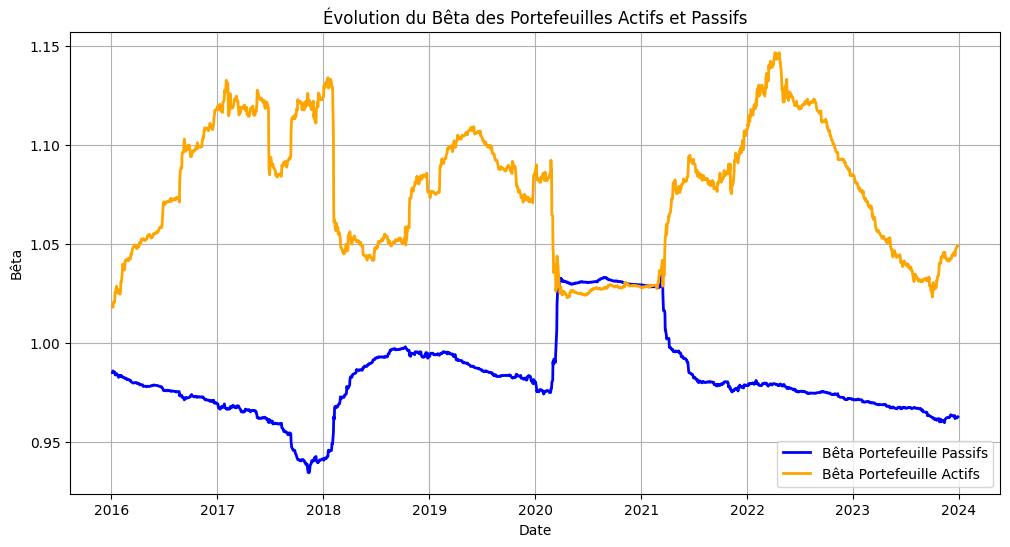

In [ ]:
##  Calcul du Bêta sur 1 an glissant

def calcul_bêta(serie_rendements_portefeuille, serie_rendements_benchmark, fenetre=252):
    cov_matrix = np.cov(serie_rendements_portefeuille[-fenetre:], serie_rendements_benchmark[-fenetre:])
    return cov_matrix[0, 1] / cov_matrix[1, 1]

bêta_passifs = []
bêta_actifs = []
dates = rendements.index[252:]

for i in range(252, len(rendements)):
    rendement_passifs = rendements['Fonds Passifs'].iloc[:i]
    rendement_actifs = rendements['Fonds Actifs'].iloc[:i]
    rendement_benchmark = rendements['Benchmark'].iloc[:i]

    bêta_passifs.append(calcul_bêta(rendement_passifs, rendement_benchmark))
    bêta_actifs.append(calcul_bêta(rendement_actifs, rendement_benchmark))

df_bêta = pd.DataFrame({
    'Date': dates,
    'Bêta Passifs': bêta_passifs,
    'Bêta Actifs': bêta_actifs
})

plt.figure(figsize=(12,6))
plt.plot(df_bêta['Date'], df_bêta['Bêta Passifs'], label='Bêta Portefeuille Passifs', color='blue', linewidth=2)
plt.plot(df_bêta['Date'], df_bêta['Bêta Actifs'], label='Bêta Portefeuille Actifs', color='orange', linewidth=2)
plt.title("Évolution du Bêta des Portefeuilles Actifs et Passifs")
plt.xlabel("Date")
plt.ylabel("Bêta")
plt.legend()
plt.grid()
plt.show()

## 3) Maximum Drawdown

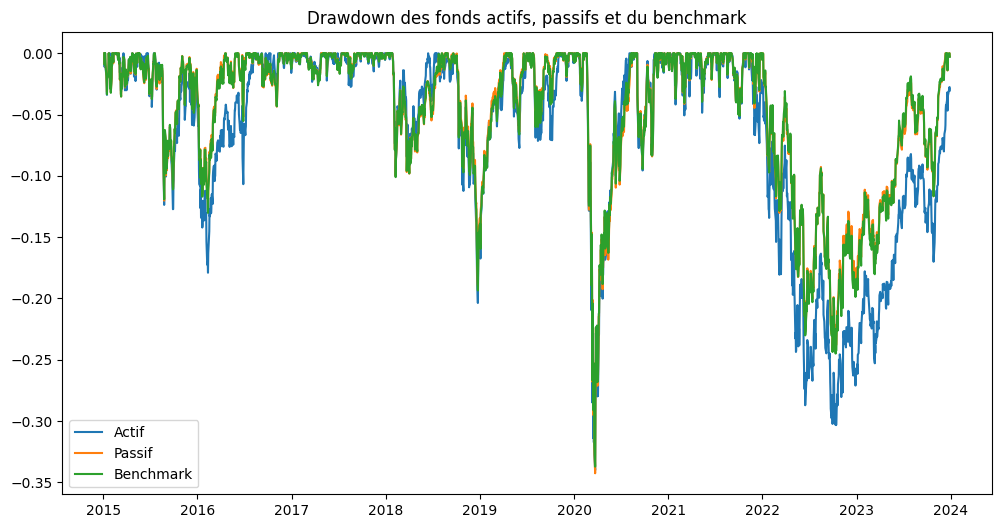

In [ ]:
# Drawdown
cumulative_returns = (1 + rendements).cumprod()
rolling_max = cumulative_returns.cummax()
drawdown = (cumulative_returns - rolling_max) / rolling_max

plt.figure(figsize=(12,6))
plt.plot(drawdown)
plt.title("Drawdown des fonds actifs, passifs et du benchmark")
plt.legend(['Actif', 'Passif', 'Benchmark'])
plt.show()

# III) Analyse de la surperformance : Exploration de la performance des fonds de gestion active face aux fonds de gestion passive

## 1) Calcul de l'Alpha (Surperformance)

[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


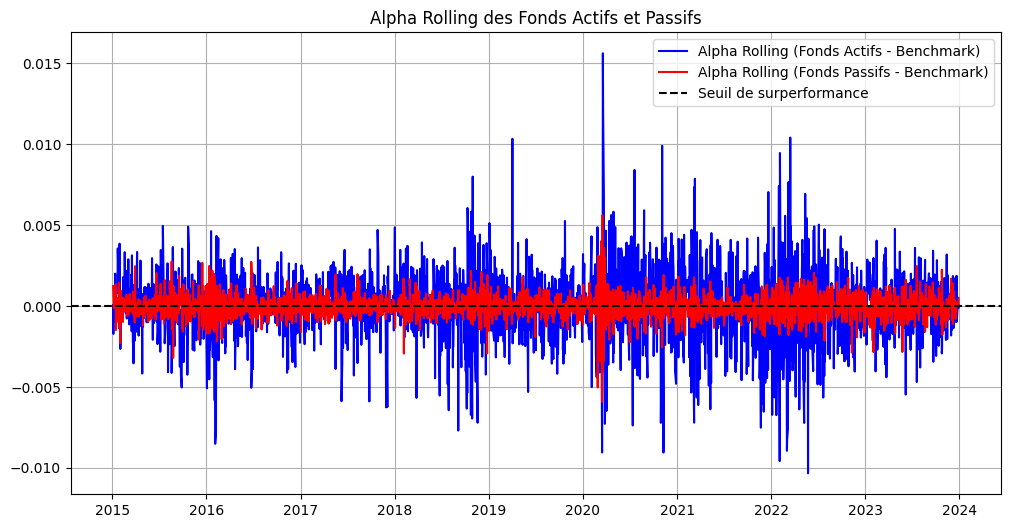

In [ ]:

# 📌 Définition des fonds passifs et actifs
fonds_passifs = ['VOO', 'IVV', 'VTI', 'SCHX', 'DIA', 'VYM', 'ITOT', 'MGK', 'SPLG', 'USMV']
fonds_actifs = ['FCNTX', 'TRBCX', 'AGTHX', 'VWUSX', 'OLGAX', 'MADVX', 'FGRIX', 'VPMCX', 'PRGFX', 'DODGX']
indice_benchmark = 'SPY'

# 📌 Téléchargement des Données
def telecharger_donnees(liste_fonds, debut='2015-01-01', fin='2024-01-01'):
    data = yf.download(liste_fonds, start=debut, end=fin)['Close']
    return data.dropna(axis=1, how='all')  # Suppression des colonnes vides

# Récupération des données des fonds et du benchmark
donnees_fonds_actifs = telecharger_donnees(fonds_actifs)
donnees_fonds_passifs = telecharger_donnees(fonds_passifs)
donnees_benchmark = telecharger_donnees([indice_benchmark])

# Fusionner les données dans un seul DataFrame
donnees_globale = pd.concat([donnees_fonds_passifs, donnees_fonds_actifs], axis=1)

# 📌 Calcul des rendements quotidiens
rendements = donnees_globale.pct_change().dropna()

# 📌 Vérification et recalcul des indices moyens si nécessaire
rendements['Fonds Actifs'] = rendements[fonds_actifs].mean(axis=1)
rendements['Fonds Passifs'] = rendements[fonds_passifs].mean(axis=1)

# 📌 Ajout du benchmark au dataframe de rendements
rendements['Benchmark'] = donnees_benchmark.pct_change().dropna()

# 📌 Vérification de la présence des colonnes nécessaires
# 📌 Calcul de l'Alpha Rolling (Surperformance par rapport au Benchmark)
alpha_actifs = rendements['Fonds Actifs'] - rendements['Benchmark']
alpha_passifs = rendements['Fonds Passifs'] - rendements['Benchmark']

# 📊 Visualisation de l'Alpha Rolling
plt.figure(figsize=(12, 6))
plt.plot(alpha_actifs, label='Alpha Rolling (Fonds Actifs - Benchmark)', color='blue')
plt.plot(alpha_passifs, label='Alpha Rolling (Fonds Passifs - Benchmark)', color='red')
plt.axhline(0, color='black', linestyle='--', label='Seuil de surperformance')
plt.title("Alpha Rolling des Fonds Actifs et Passifs")
plt.legend()
plt.grid()
plt.show()

## 2) Régression OLS : Analyse de l’Alpha des Fonds Actifs vs Passifs



[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


                            OLS Regression Results                            
Dep. Variable:                  Alpha   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                 -0.034
Method:                 Least Squares   F-statistic:                    0.3818
Date:                Thu, 13 Mar 2025   Prob (F-statistic):              0.544
Time:                        11:53:01   Log-Likelihood:                 170.09
No. Observations:                  20   AIC:                            -336.2
Df Residuals:                      18   BIC:                            -334.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        2.56e-06   1.63e-05      0.157      0.8

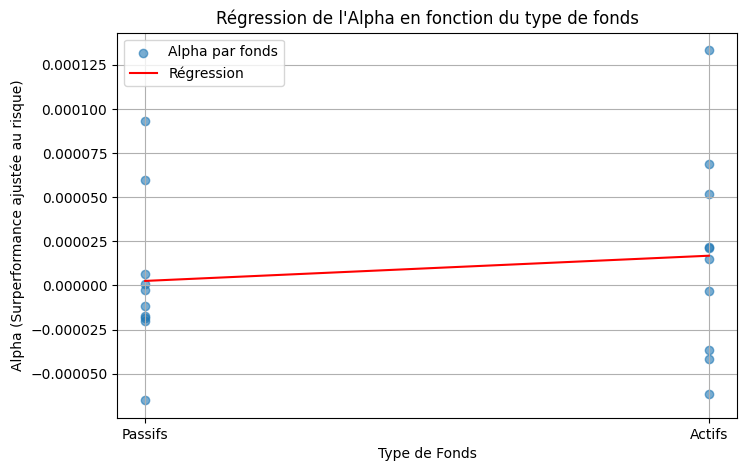

In [ ]:

# Définition des fonds passifs et actifs
fonds_passifs = ['VOO', 'IVV', 'VTI', 'SCHX', 'DIA', 'VYM', 'ITOT', 'MGK', 'SPLG', 'USMV']
fonds_actifs = ['FCNTX', 'TRBCX', 'AGTHX', 'VWUSX', 'OLGAX', 'MADVX', 'FGRIX', 'VPMCX', 'PRGFX', 'DODGX']
indice_benchmark = 'SPY'

# Téléchargement des données
def telecharger_donnees(liste_fonds, debut='2015-01-01', fin='2024-01-01'):
    return yf.download(liste_fonds, start=debut, end=fin)['Close']

donnees_actifs = telecharger_donnees(fonds_actifs)
donnees_passifs = telecharger_donnees(fonds_passifs)
donnees_benchmark = telecharger_donnees([indice_benchmark])[indice_benchmark]

# Calcul des rendements quotidiens
rendements_actifs = donnees_actifs.pct_change().dropna()
rendements_passifs = donnees_passifs.pct_change().dropna()
rendements_benchmark = donnees_benchmark.pct_change().dropna()

# Alignement des dates
rendements_actifs = rendements_actifs.loc[rendements_benchmark.index]
rendements_passifs = rendements_passifs.loc[rendements_benchmark.index]

# Taux sans risque quotidien
taux_sans_risque_annuel = 0.0425  # 4,25%
taux_sans_risque_quotidien = (1 + taux_sans_risque_annuel) ** (1/252) - 1

# Calcul des rendements excédentaires
rendements_exc_benchmark = rendements_benchmark - taux_sans_risque_quotidien
rendements_exc_actifs = rendements_actifs.subtract(taux_sans_risque_quotidien, axis=0)
rendements_exc_passifs = rendements_passifs.subtract(taux_sans_risque_quotidien, axis=0)

# Fonction pour calculer Alpha et Beta pour chaque fonds
def calculer_alpha_beta(rendements_exc_fonds, rendements_exc_benchmark):
    alphas, betas = [], []

    for fonds in rendements_exc_fonds.columns:
        X = sm.add_constant(rendements_exc_benchmark)  # Ajout de l'intercept pour capturer alpha
        y = rendements_exc_fonds[fonds]

        model = sm.OLS(y, X).fit()
        alphas.append(model.params['const'])  # Alpha (intercept)
        betas.append(model.params[indice_benchmark])  # Beta (sensibilité au marché)

    return alphas, betas

# Calcul des alphas et betas
alphas_actifs, betas_actifs = calculer_alpha_beta(rendements_exc_actifs, rendements_exc_benchmark)
alphas_passifs, betas_passifs = calculer_alpha_beta(rendements_exc_passifs, rendements_exc_benchmark)

# Création du DataFrame des résultats
df_alpha_beta = pd.DataFrame({
    'Type': ['Actif'] * len(alphas_actifs) + ['Passif'] * len(alphas_passifs),
    'Alpha': alphas_actifs + alphas_passifs,
    'Beta': betas_actifs + betas_passifs
})

# Régression de l'alpha sur le type de fonds
X = sm.add_constant(df_alpha_beta['Type'].map({'Actif': 1, 'Passif': 0}))  # Encodage 1 = Actif, 0 = Passif
y = df_alpha_beta['Alpha']

model = sm.OLS(y, X).fit()
print(model.summary())

# Visualisation
plt.figure(figsize=(8, 5))
plt.scatter(df_alpha_beta['Type'].map({'Actif': 1, 'Passif': 0}), df_alpha_beta['Alpha'], alpha=0.6, label="Alpha par fonds")
plt.plot(df_alpha_beta['Type'].map({'Actif': 1, 'Passif': 0}), model.fittedvalues, color='red', label="Régression")
plt.xticks([0, 1], ['Passifs', 'Actifs'])
plt.xlabel("Type de Fonds")
plt.ylabel("Alpha (Surperformance ajustée au risque)")
plt.title("Régression de l'Alpha en fonction du type de fonds")
plt.legend()
plt.grid()
plt.show()

## 3) Superfomance en prenant en compte les frais de gestion

[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed


                     Court Terme (1 an)                                   \
                       Rendement Ajusté Volatilité Ajustée Sharpe Ajusté   
Portefeuille Passifs           0.236248           0.124768      1.893504   
Portefeuille Actifs            0.300227           0.140539      2.136253   

                     Moyen Terme (3 ans)                                   \
                        Rendement Ajusté Volatilité Ajustée Sharpe Ajusté   
Portefeuille Passifs            0.104828           0.167951      0.624161   
Portefeuille Actifs             0.077930           0.194460      0.400751   

                     Long Terme (Toute la période)                     \
                                  Rendement Ajusté Volatilité Ajustée   
Portefeuille Passifs                      0.125988           0.177357   
Portefeuille Actifs                       0.127774           0.192336   

                                    
                     Sharpe Ajusté  
Portefeuille Passif

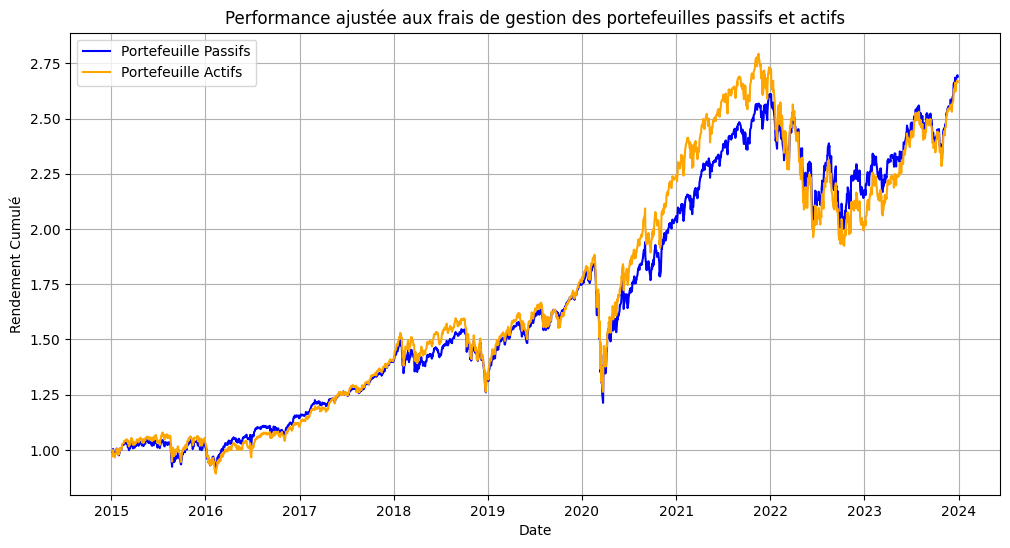

In [ ]:

# Définition des fonds passifs et actifs
fonds_passifs = ['VOO', 'IVV', 'VTI', 'SCHX', 'DIA', 'VYM', 'ITOT', 'MGK', 'SPLG', 'USMV']
fonds_actifs = ['FCNTX', 'TRBCX', 'AGTHX', 'VWUSX', 'OLGAX', 'MADVX', 'FGRIX', 'VPMCX', 'PRGFX', 'DODGX']

# Frais de gestion annuels spécifiques (%)
frais_gestion = {
    'VOO': 0.03, 'IVV': 0.03, 'VTI': 0.03, 'SCHX': 0.04, 'DIA': 0.16,
    'VYM': 0.06, 'ITOT': 0.03, 'MGK': 0.07, 'SPLG': 0.02, 'USMV': 0.15,
    'FCNTX': 0.79, 'TRBCX': 0.72, 'AGTHX': 0.64, 'VWUSX': 0.94, 'OLGAX': 0.83,
    'MADVX': 0.98, 'FGRIX': 0.91, 'VPMCX': 0.89, 'PRGFX': 0.85, 'DODGX': 0.62
}

# 📌 Téléchargement des données
def telecharger_donnees(liste_fonds, debut='2015-01-01', fin='2024-01-01'):
    data = yf.download(liste_fonds, start=debut, end=fin)['Close']
    return data.dropna(axis=1, how='all')

# Récupération des données
donnees_fonds_actifs = telecharger_donnees(fonds_actifs)
donnees_fonds_passifs = telecharger_donnees(fonds_passifs)
donnees_globale = pd.concat([donnees_fonds_passifs, donnees_fonds_actifs], axis=1)

# 📌 Calcul des rendements quotidiens
rendements = donnees_globale.pct_change().dropna()

# 📌 Ajustement des rendements avec les frais de gestion
rendements_ajustes = rendements.copy()
for fonds in rendements.columns:
    if fonds in frais_gestion:
        rendements_ajustes[fonds] -= (frais_gestion[fonds] / 100) / 252  # Ajustement quotidien

# 📌 Définition des horizons temporels
periode_court_terme = 252  # 1 an
periode_moyen_terme = 252 * 3  # 3 ans

# 📌 Fonction pour calculer les performances d'un portefeuille
def calculer_performance_portefeuille(rendements):
    rendement_annuel = rendements.mean().mean() * 252
    volatilite_annuelle = rendements.mean(axis=1).std() * np.sqrt(252)
    sharpe = rendement_annuel / volatilite_annuelle
    return rendement_annuel, volatilite_annuelle, sharpe

# 📌 Calcul des performances des portefeuilles pour chaque horizon
resultats = {}

for horizon, periode in zip(["Court Terme (1 an)", "Moyen Terme (3 ans)", "Long Terme (Toute la période)"],
                             [periode_court_terme, periode_moyen_terme, len(rendements_ajustes)]):
    rendements_court = rendements_ajustes.tail(periode)

    rendement_passifs, volatilite_passifs, sharpe_passifs = calculer_performance_portefeuille(rendements_court[fonds_passifs])
    rendement_actifs, volatilite_actifs, sharpe_actifs = calculer_performance_portefeuille(rendements_court[fonds_actifs])

    resultats[horizon] = {
        "Portefeuille Passifs": [rendement_passifs, volatilite_passifs, sharpe_passifs],
        "Portefeuille Actifs": [rendement_actifs, volatilite_actifs, sharpe_actifs]
    }

# 📌 Création d'un DataFrame pour l'affichage
tableau_performance = pd.concat({horizon: pd.DataFrame(resultats[horizon],
                                                        index=["Rendement Ajusté", "Volatilité Ajustée", "Sharpe Ajusté"]).T
                                  for horizon in resultats}, axis=1)

# 📌 Affichage formaté
pd.set_option("display.float_format", "{:.6f}".format)
print(tableau_performance)

# 📊 Visualisation des rendements cumulés ajustés
plt.figure(figsize=(12, 6))
plt.plot((1 + rendements_ajustes[fonds_passifs].mean(axis=1)).cumprod(), label="Portefeuille Passifs", color='blue')
plt.plot((1 + rendements_ajustes[fonds_actifs].mean(axis=1)).cumprod(), label="Portefeuille Actifs", color='orange')

plt.legend()
plt.title("Performance ajustée aux frais de gestion des portefeuilles passifs et actifs")
plt.xlabel("Date")
plt.ylabel("Rendement Cumulé")
plt.grid()
plt.show()

## 3) Regression pour voir si la performance de la gestion active provient du hasard ou si ce n'est que du au alpha

[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


                            OLS Regression Results                            
Dep. Variable:                  Alpha   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                 -0.034
Method:                 Least Squares   F-statistic:                    0.3818
Date:                Thu, 13 Mar 2025   Prob (F-statistic):              0.544
Time:                        11:51:31   Log-Likelihood:                 170.09
No. Observations:                  20   AIC:                            -336.2
Df Residuals:                      18   BIC:                            -334.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        2.56e-06   1.63e-05      0.157      0.8

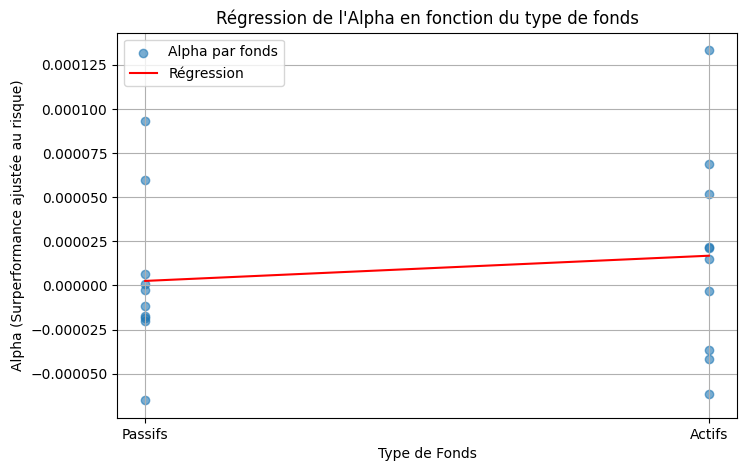

In [ ]:

# Définition des fonds passifs et actifs
fonds_passifs = ['VOO', 'IVV', 'VTI', 'SCHX', 'DIA', 'VYM', 'ITOT', 'MGK', 'SPLG', 'USMV']
fonds_actifs = ['FCNTX', 'TRBCX', 'AGTHX', 'VWUSX', 'OLGAX', 'MADVX', 'FGRIX', 'VPMCX', 'PRGFX', 'DODGX']
indice_benchmark = 'SPY'

# Téléchargement des données
def telecharger_donnees(liste_fonds, debut='2015-01-01', fin='2024-01-01'):
    return yf.download(liste_fonds, start=debut, end=fin)['Close']

donnees_actifs = telecharger_donnees(fonds_actifs)
donnees_passifs = telecharger_donnees(fonds_passifs)
donnees_benchmark = telecharger_donnees([indice_benchmark])[indice_benchmark]

# Calcul des rendements quotidiens
rendements_actifs = donnees_actifs.pct_change().dropna()
rendements_passifs = donnees_passifs.pct_change().dropna()
rendements_benchmark = donnees_benchmark.pct_change().dropna()

# Alignement des dates
rendements_actifs = rendements_actifs.loc[rendements_benchmark.index]
rendements_passifs = rendements_passifs.loc[rendements_benchmark.index]

# Taux sans risque quotidien
taux_sans_risque_annuel = 0.0425  # 4,25%
taux_sans_risque_quotidien = (1 + taux_sans_risque_annuel) ** (1/252) - 1

# Calcul des rendements excédentaires
rendements_exc_benchmark = rendements_benchmark - taux_sans_risque_quotidien
rendements_exc_actifs = rendements_actifs.subtract(taux_sans_risque_quotidien, axis=0)
rendements_exc_passifs = rendements_passifs.subtract(taux_sans_risque_quotidien, axis=0)

# Fonction pour calculer Alpha et Beta pour chaque fonds
def calculer_alpha_beta(rendements_exc_fonds, rendements_exc_benchmark):
    alphas, betas = [], []

    for fonds in rendements_exc_fonds.columns:
        X = sm.add_constant(rendements_exc_benchmark)  # Ajout de l'intercept pour capturer alpha
        y = rendements_exc_fonds[fonds]

        model = sm.OLS(y, X).fit()
        alphas.append(model.params['const'])  # Alpha (intercept)
        betas.append(model.params[indice_benchmark])  # Beta (sensibilité au marché)

    return alphas, betas

# Calcul des alphas et betas
alphas_actifs, betas_actifs = calculer_alpha_beta(rendements_exc_actifs, rendements_exc_benchmark)
alphas_passifs, betas_passifs = calculer_alpha_beta(rendements_exc_passifs, rendements_exc_benchmark)

# Création du DataFrame des résultats
df_alpha_beta = pd.DataFrame({
    'Type': ['Actif'] * len(alphas_actifs) + ['Passif'] * len(alphas_passifs),
    'Alpha': alphas_actifs + alphas_passifs,
    'Beta': betas_actifs + betas_passifs
})

# Régression de l'alpha sur le type de fonds
X = sm.add_constant(df_alpha_beta['Type'].map({'Actif': 1, 'Passif': 0}))  # Encodage 1 = Actif, 0 = Passif
y = df_alpha_beta['Alpha']

model = sm.OLS(y, X).fit()
print(model.summary())

# Visualisation
plt.figure(figsize=(8, 5))
plt.scatter(df_alpha_beta['Type'].map({'Actif': 1, 'Passif': 0}), df_alpha_beta['Alpha'], alpha=0.6, label="Alpha par fonds")
plt.plot(df_alpha_beta['Type'].map({'Actif': 1, 'Passif': 0}), model.fittedvalues, color='red', label="Régression")
plt.xticks([0, 1], ['Passifs', 'Actifs'])
plt.xlabel("Type de Fonds")
plt.ylabel("Alpha (Surperformance ajustée au risque)")
plt.title("Régression de l'Alpha en fonction du type de fonds")
plt.legend()
plt.grid()
plt.show()
